In [116]:
from itertools import combinations
from collections import defaultdict, namedtuple, deque
from math import isclose
from operator import eq

import uuid

import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection
from matplotlib.patches import Polygon
from matplotlib.collections import PolyCollection

class Point:
    def __init__(self, k_values, cos_list, sin_list, mid_point):
        # Save two different locations: base and centered
        self.k_values = k_values
        
        self.location = np.array([0, 0], dtype=float)
        for k, c, s in zip(k_values, cos_list, sin_list):
            self.location += k * np.array([c, s])
        self.location -= mid_point

    def __str__(self):
        return f'{self.k_values}'

class Line:
    # a*x + b*y = c
    def __init__(self, a, b, o, k=0, grid=None):
        self.a = a
        self.b = b
        self.c = o + k
        self.offset = o
        self.k = k
        self.grid = grid

        # Angle off horizontal
        self.first_angle = np.arctan2(-a, b)
        if self.first_angle < 0:
            self.second_angle = self.first_angle + np.pi
        else:
            self.second_angle = self.first_angle - np.pi

        # crossing counter clockwise, first angle is k + 1, second is k
        # because of how np.arctan2 works?
        Angle = namedtuple('Angle', ['value', 'k', 'grid'])

        self.angles = [Angle(self.first_angle, self.k + 1, grid), 
                       Angle(self.second_angle, self.k, grid)]

        # Find closes point to the origin
        self.origin_x = (self.a * self.c) / (self.a**2 + self.b**2)
        self.origin_y = (self.b * self.c) / (self.a**2 + self.b**2)

        self.perpendicular_angle = np.arctan2(b, a)

        # Keep this stuff in here for testing, but add parameter to exclude it later
        self.p1 = [np.cos(self.perpendicular_angle) * .25 + self.origin_x,
              np.sin(self.perpendicular_angle) * .25 + self.origin_y ]
        self.p2 = [np.cos(self.perpendicular_angle) * -.25 + self.origin_x,
              np.sin(self.perpendicular_angle) * -.25 + self.origin_y ]

    def __str__(self):
        return f'a={self.a}, b={self.b}, offset={self.offset}, k={self.k}, grid={self.grid}'

    def determine_intersection(self, other_line):

        denom = (self.a * other_line.b) - (other_line.a * self.b)
        if isclose(denom, 0, rel_tol=1e-5, abs_tol=1e-05):
            # Determine if it's the same line

            if isclose(other_line.a, 0, rel_tol=1e-5, abs_tol=1e-05):
                if not isclose(self.a, 0, rel_tol=1e-5, abs_tol=1e-05):
                    # Different lines
                    return None
                a_proportion = 0
            else:
                a_proportion = self.a / other_line.a
            
            if isclose(other_line.b, 0, rel_tol=1e-5, abs_tol=1e-05):
                if not isclose(self.b, 0, rel_tol=1e-5, abs_tol=1e-05):
                    # Different lines
                    return None
                b_proportion = 0
            else:
                b_proportion = self.b / other_line.b

            if a_proportion and b_proportion:
                if not isclose(a_proportion, b_proportion):
                    return None

            if isclose(other_line.c, 0, rel_tol=1e-5, abs_tol=1e-05):
                if not isclose(self.c, 0, rel_tol=1e-5, abs_tol=1e-05):
                    # Different lines
                    return None
                c_proportion = 0
            else:
                c_proportion = self.c / other_line.c

            if a_proportion and c_proportion:
                if not isclose(a_proportion, c_proportion, rel_tol=1e-5, abs_tol=1e-05):
                    return None
            
            if b_proportion and c_proportion:
                if not isclose(b_proportion, c_proportion, rel_tol=1e-5, abs_tol=1e-05):
                    return None

            raise OverlappingLines(self, other_line)
        else:
            x = (other_line.b * self.c) - (self.b * other_line.c)
            x = x / denom

            y = (self.a * other_line.c) - (other_line.a * self.c)
            y = y / denom

            return (np.round(x, 7), np.round(y, 7))
        
    def draw_line(self, ax):
        '''
        l = Line(1, 1, 0)

        fig, ax = plt.subplots()
        l.draw_line(ax)
        plt.show()
        '''

        graph_points = []

        # Crosses x-axis
        if self.b != 0:
            graph_points.append((-5, (self.c - self.a*-5)/self.b))
            graph_points.append((0, self.c/self.b))
            graph_points.append((5, (self.c - self.a*5)/self.b))

        # Crosses y-axis
        if self.a != 0:
            graph_points.append(((self.c - self.b*-5)/self.a, -5))
            graph_points.append((self.c/self.a, 0))
            graph_points.append(((self.c - self.b*5)/self.a, 5))

        min_x = np.Inf
        max_x = -np.Inf
        min_y = np.Inf
        max_y = -np.Inf

        for i in graph_points:
            if i[0] < min_x:
                min_x = i[0]
            if i[0] > max_x:
                max_x = i[0]
            if i[1] < min_y:
                min_y = i[1]
            if i[1] > max_y:
                max_y = i[1]

        if min_x == max_x:
            min_x, max_x = -5, 5
        if min_y == max_y:
            min_y, max_y = -5, 5

        ax.axhline(0, color='gray', linestyle="--")
        ax.axvline(0, color='gray', linestyle="--")
        ax.add_collection(LineCollection([graph_points]))
        ax.set_xlim(min_x, max_x)
        ax.set_ylim(min_y, max_y)
        ax.set_aspect('equal')
        return ax
        
class OverlappingLines(Exception):
    def __init__(self, line_1, line_2, msg="These two lines are the same line."):
        self.line_1 = line_1
        self.line_2 = line_2
        self.msg = msg
        super().__init__(self.msg)

    def __str__(self):
        return f'{self.msg}\n\t{self.line_1}\n\t{self.line_2}'
    
class Edge:
    '''Class used for tile edges, doesn't relate to the Line class'''
    def __init__(self, point_ids, tile_id):
        # Switch out points lookup to individual points
        self.points = point_ids
        self.tile_ids = [tile_id]

    def add_tile_id(self, tile_id):
        self.tile_ids.append(tile_id)
        
        if len(self.tile_ids) > 2:
            raise OverusedEdge(self)
        
    def __str__(self):
        msg = f'point_ids: {self.points}'
        for t in self.tile_ids:
            msg = msg + f'\n\t{t}'
        return msg
    
class OverusedEdge(Exception):
    '''Happens when the floating point fails on a point with multiple lines'''
    def __init__(self, edge, msg="This edge has more than two tiles."):
        self.edge = edge
        self.msg = msg
        super().__init__(self.msg)

    def __str__(self):
        return f'{self.msg}\n\t{self.edge}'
        
class Tile:
    def __init__(self, tile_points, intersection_points, intersection_lines):
        self.tile_points = tile_points
        self.intersection_points = intersection_points
        self.intersection_lines = intersection_lines
        self.tile_group = 0

        self.tile_id = uuid.uuid4()
        self.connected = False

        # Don't need to compare distances between angles, always 1 by construction
        # Change angles to interior_angles
        self.angles = []
        for previous_point, tile_point, next_point in zip([self.tile_points[-1]] + self.tile_points[:-1],
                                 self.tile_points,
                                 self.tile_points[1:] + [self.tile_points[0]]):

            point_location = tile_point.location
            previous_point_location = previous_point.location
            next_point_location = next_point.location

            in_vector = point_location - previous_point_location
            out_vector = next_point_location - point_location
            angle = np.arctan2(in_vector[0]*out_vector[1]-in_vector[1]*out_vector[0],
                            in_vector[0]*out_vector[0]+in_vector[1]*out_vector[1])

            self.angles.append(angle)

    def compare_angles(self, other_polygon):
        if len(self.angles) != len(other_polygon.angles):
            return False

        angles_repeated = self.angles + self.angles
        for a in np.arange(len(self.angles)):
            match = True
            for b in np.arange(len(other_polygon.angles)):
                if not isclose(angles_repeated[a + b], other_polygon.angles[b], rel_tol=1e-5, abs_tol=1e-05):
                    match = False
                    break
            if match:
                return True
        return False
    
    def draw_tile(self, ax):
        '''
        cos_list = [1, 0, -1, 0]
        sin_list = [0, 1, 0, -1]
        mid_point = np.array([0, 0], dtype=float)

        points = [Point((1.0, 0.0, 0.0, 0.0), cos_list, sin_list, mid_point),
                Point((1.0, 1.0, 0.0, 0.0), cos_list, sin_list, mid_point),
                Point((0.0, 1.0, 0.0, 0.0), cos_list, sin_list, mid_point),
                Point((0.0, 0.0, 0.0, 0.0), cos_list, sin_list, mid_point)]
        lines = [Line(0, 1, .25, 0, 1),
                Line(1, 0, .25, 0, 2)]
        t = Tile(points, (.25, .25), lines)
        fig, ax = plt.subplots()
        t.draw_tile(ax)
        plt.show()
        '''
        min_x = np.Inf
        max_x = -np.Inf
        min_y = np.Inf
        max_y = -np.Inf

        line_base_point = self.intersection_points
        tile_points = []
        for tp in self.tile_points:
            if tp.location[0] < min_x:
                min_x = tp.location[0]
            if tp.location[0] > max_x:
                max_x = tp.location[0]
            if tp.location[1] < min_y:
                min_y = tp.location[1]
            if tp.location[1] > max_y:
                max_y = tp.location[1]
            tile_points.append(tp.location.copy())

        midpoint_x = 0
        midpoint_y = 0

        for p in tile_points:
            midpoint_x += p[0]
            midpoint_y += p[1]

        midpoint_x = midpoint_x / len(tile_points)
        midpoint_y = midpoint_y / len(tile_points)

        for p in tile_points:
            p[0] = p[0] - midpoint_x + line_base_point[0]
            p[1] = p[1] - midpoint_y + line_base_point[1]

        min_x -= 1
        max_x += 1
        min_y -= 1
        max_y += 1

        # Lines stuff
        line_base_point = self.intersection_points
        line_min_x = self.intersection_points[0] - 2
        line_max_x = self.intersection_points[0] + 2
        line_min_y = self.intersection_points[1] - 2
        line_max_y = self.intersection_points[1] + 2
        boundary = [Line(1, 0, line_min_x, 0), 
                    Line(1, 0, line_max_x, 0), 
                    Line(0, 1, line_min_y, 0), 
                    Line(0, 1, line_max_y, 0)]

        draw_lines = []

        for l in self.intersection_lines:
            points = []
            for b in boundary:
                intersection = l.determine_intersection(b)
                if (intersection and 
                    intersection[0] >= (line_min_x - .5) and 
                    intersection[0] <= (line_max_x + .5) and
                    intersection[1] >= (line_min_y - .5) and
                    intersection[1] <= (line_max_y + .5)):
                    points.append(intersection)
            draw_lines.append(points)

        ax.add_collection(LineCollection(draw_lines))
        ax.add_patch(Polygon(tile_points, facecolor = 'w', edgecolor="k"))
        ax.set_xlim(line_min_x, line_max_x)
        ax.set_ylim(line_min_y, line_max_y)
        ax.set_aspect('equal')
        
        return ax
    
    def draw_line_angles(self, ax):
        angles = [np.pi * x /4 for x in range(-4, 4, 1)]
        angles_color = ['black' for x in angles]

        for l in self.intersection_lines:
            angles.extend([l.angles[0].value, l.angles[1].value])
            angles_color.extend(['red', 'red'])

        draw_lines = []
        text_location = []

        for angle in angles:
            draw_lines.append([(0, 0), (np.cos(angle), np.sin(angle))])
            text_location.append([1.10 * np.cos(angle), 1.10 * np.sin(angle)])

        ax.add_collection(LineCollection(draw_lines, colors=angles_color))
        for tl, a in zip(text_location, angles):
            ax.text(tl[0], tl[1], f'{a:.2f}')
        ax.set_xlim(-1.5, 1.5)
        ax.set_ylim(-1.5, 1.5)
        ax.axis('off')
        ax.set_aspect('equal')
        
        return ax
    
class MultiGrid:
    def __init__(self, seed=None, grid_count=None, 
                      grid_bounds=[], rotation=None, 
                      base_point = (),
                      offsets=[], colors=[]):
        self.seed = seed
        self.rng = np.random.default_rng(self.seed)
        
        if not grid_count:
            grid_count = self.rng.integers(low=3, high=20)
        self.grid_count = grid_count

        if not grid_bounds:
            grid_bounds = self.rng.integers(low=2, high=10)
            grid_bounds = [-grid_bounds, grid_bounds+1]
        self.grid_bounds = grid_bounds

        if rotation is None:
            rotation = self.rng.uniform(low=0, high=(2 * np.pi / grid_count))
        self.rotation = rotation

        self.cos_list = [np.cos(x * 2 * np.pi / self.grid_count + self.rotation) for x in np.arange(self.grid_count)]
        self.sin_list = [np.sin(x * 2 * np.pi / self.grid_count + self.rotation) for x in np.arange(self.grid_count)]

        if not offsets:
            offsets = self.rng.uniform(size=grid_count)
            if sum(offsets) != 0:
                offsets = offsets / sum(offsets)
        self.offsets = offsets

        if colors:
            self.colors = colors
        else:
            self.colors = []

        if not base_point:
            r = 25 * np.sqrt(self.rng.random())
            theta = self.rng.random() * 2 * np.pi
            base_point = np.array([r * np.cos(theta),
                                        r * np.sin(theta), 0], dtype=float)
        self.base_point = base_point

        base_k_values = []
        for c, s, o in zip(self.cos_list, self.sin_list, offsets):
            base_k_values.append(self.determine_base_K(self.base_point, c, s, o))        

        self.grids = []
        for i, (s, c, o, bk) in enumerate(zip(self.sin_list, self.cos_list, offsets, base_k_values)):
            for k in np.arange(*grid_bounds):
                self.grids.append(Line(c, s, o, bk + k, i))
        self.grid_colors = [self.oklab(.75, .1 * c, .1 * s) for c, s in zip(self.cos_list, self.sin_list)]

        self.mid_point = np.array([0, 0], dtype=float)
        for k, c, s in zip(base_k_values, self.cos_list, self.sin_list):
            self.mid_point += k * np.array([c, s])

    def update_edges(self, points, tile_id):
        if points in self.edges:
            self.edges[points].add_tile_id(tile_id)
        else:
            self.edges[points] =  Edge(points, tile_id)

    def create_tiles(self):

        self.points = {}

        self.edges = {}  

        self.intersections = defaultdict(set)
        for pair in combinations(self.grids, 2):
            l1 = pair[0]
            l2 = pair[1]
            
            if l1.grid == l2.grid:
                continue

            try:
                intersection = l1.determine_intersection(l2)
                if intersection:
                    self.intersections[intersection].update([l1, l2])
            except OverlappingLines as e: 
                print(e)
                raise

        self.base_tiles = []
        self.tiles = {}

        for intersection_points, intersection_lines in self.intersections.items():

            # No, remove intersection information from tiles, put into own class, build two graphing functions that return ax

            # Maybe, get all the angles in order
            angles = []
            for l in intersection_lines:
                angles.extend(l.angles.copy())
            angles.sort()

            # #start with right above (or below) the first one, (maybe need to get to second+ line to get all the K's) then continue looping through
            # Set up K values for the other lines
            ks = [self.determine_K(c, intersection_points[0], s, intersection_points[1], o) for c, s, o in zip(self.cos_list, self.sin_list, self.offsets)]

            # Now spin around to ensure the ks are correct on the lines that intersect
            for angle in angles:
                ks[angle.grid] = angle.k

            tile_points = []
            for angle in angles:
                ks[angle.grid] = angle.k

                k_values = tuple(ks)
                if not k_values in self.points:
                    self.points[k_values] = Point(k_values, self.cos_list, self.sin_list, self.mid_point)

                tile_points.append(self.points[k_values])

            t = Tile(tile_points, intersection_points, intersection_lines)

            for t_current, t_next in zip(t.tile_points, t.tile_points[1:] + [t.tile_points[0]]):
                # Check left to right, then down to up
                if t_current.location[1] < t_next.location[1]:
                    self.update_edges(points=(t_current.k_values, t_next.k_values), tile_id=t.tile_id)
                elif t_next.location[1] < t_current.location[1]:
                    self.update_edges(points=(t_next.k_values, t_current.k_values), tile_id=t.tile_id)
                elif t_current.location[0] < t_next.location[0]:
                    self.update_edges(points=(t_current.k_values, t_next.k_values), tile_id=t.tile_id)
                else:
                    self.update_edges(points=(t_next.k_values, t_current.k_values), tile_id=t.tile_id)

            bt_match = False
            for bt in self.base_tiles:
                if bt.compare_angles(t):
                    t.tile_group = bt.tile_group
                    bt_match = True
                    break

            if not bt_match:
                t.tile_group = len(self.base_tiles)
                self.base_tiles.append(t)

            self.tiles[t.tile_id] = t

    def remove_unconnected_tiles(self):

        # Could add neighbor ids into the tile class?, that would remove the edge class, then add exception into the tile class?
        neighbors = defaultdict(list)
        for edge in self.edges.values():
            if len(edge.tile_ids) == 2:
                neighbors[edge.tile_ids[0]].append(edge.tile_ids[1])
                neighbors[edge.tile_ids[1]].append(edge.tile_ids[0])

        # Find center-ish tile
        # Change to while loop until finding a point close to center
        # abs(location) < 1.5
        center_tile = self.tiles[list(self.tiles.keys())[0]]
        center_point = center_tile.tile_points[0]
        center_distance = center_point.location[0]**2 + center_point.location[1]**2
        for tile in self.tiles.values():
            tile_point = tile.tile_points[0]
            tile_distance = tile_point.location[0]**2 + tile_point.location[1]**2
            if tile_distance < center_distance:
                center_tile = tile
                center_point = tile_point
                center_distance = tile_distance

        center_tile.connected = True
        connected_tiles = deque([center_tile])

        while connected_tiles:
            current_tile = connected_tiles.pop()
            for neighbor in neighbors[current_tile.tile_id]:
                neighbor_tile = self.tiles[neighbor]
                if not neighbor_tile.connected:
                    neighbor_tile.connected = True
                    connected_tiles.append(neighbor_tile)

        # Now, delete the not connected tiles
        for k in list(self.tiles.keys()):
            if not self.tiles[k].connected:
                del self.tiles[k]

        remove_edges = []
        for edge in self.edges.values():
            for t in edge.tile_ids.copy():
                if t not in self.tiles:
                    edge.tile_ids.remove(t)

            if not edge.tile_ids:
                remove_edges.append(edge.points)

        for edge in remove_edges:
            del self.edges[edge]

    def draw_image(self, ax):
        '''
        mg = MultiGrid(grid_count=5, 
                            grid_bounds=[-5, 5], rotation=0, 
                            base_point = [0, 0],
                            offsets=[.2, .2, .2, .2, .2])
        mg.create_tiles()
        mg.remove_unconnected_tiles()
        fig, ax = plt.subplots(figsize=figsize)
        ax = self.draw_image(ax)
        plt.tight_layout()
        plt.show()
        '''
        closest_distance = np.inf

        for edge in self.edges.values():
            if len(edge.tile_ids) == 1:
                for p in edge.points:
                    p_distance = self.points[p].location[0] ** 2 + self.points[p].location[1] ** 2
                    if p_distance < closest_distance:
                        closest_distance = p_distance

        closest_distance = np.sqrt(closest_distance)

        image_bounds = closest_distance / np.sqrt(2)

        if not self.colors:
            for i in range(len(self.base_tiles) + 1):
                self.colors.append(self.random_color())

        polygons = []
        polygon_colors = []
        for t in self.tiles.values():
            locations = []
            for p in t.tile_points:
                locations.append(p.location)

            polygons.append(locations)
            polygon_colors.append(self.colors[t.tile_group])
                            
        polygon_collection = PolyCollection(polygons, facecolor=polygon_colors, edgecolor=self.colors[-1])
        ax.add_collection(polygon_collection)
        ax.set_aspect('equal')
        ax.axis([-image_bounds, image_bounds, -image_bounds, image_bounds])
        ax.axis('off')

    def save_image(self, image_location, figsize=(5, 5), dpi=150):
        '''
        mg = MultiGrid(grid_count=5, 
                            grid_bounds=[-5, 5], rotation=0, 
                            base_point = [0, 0],
                            offsets=[.2, .2, .2, .2, .2])
        mg.create_tiles()
        mg.remove_unconnected_tiles()
        mg.save_image('output/graph.png')
        '''

        fig, ax = plt.subplots(figsize=figsize)
        ax = self.draw_image(ax)
        plt.tight_layout(pad=0)
        plt.savefig(image_location, dpi=dpi)
        plt.close()

    def determine_base_K(self, p, c, s, o):
        # If it's on a line, lower it to the origin
        if isclose(((c * p[0] + s * p[1]) % 1), o, rel_tol=1e-5, abs_tol=1e-05):
            p_distance = np.sqrt(p[0]**2 + p[1]**2)
            if p_distance:
                p_normal_origin = [-p_ / p_distance * .5 for p_ in p]
                p = [p + pno for p, pno in zip(p, p_normal_origin)]
            else:
                return 0

        base_k = np.ceil(c * p[0] + s * p[1] - o) # change to use determine_K
        return base_k

    def determine_K(self, c, x, s, y, o):
        return np.ceil(c * x + s * y - o)

    def random_color(self):
        converts_rgb = False

        while not converts_rgb:
            L = self.rng.uniform(0, 1)
            a = self.rng.uniform(-.3, .3)
            b = self.rng.uniform(-.3, .3)

            rgb = self.oklab(L, a, b)

            if ((0 <= rgb[0] and rgb[0] <= 1) and
                (0 <= rgb[1] and rgb[1] <= 1) and
                (0 <= rgb[2] and rgb[2] <= 1)):
                converts_rgb = True

        return rgb
    
    def oklab(self, L, a, b):
        l_ = L + 0.3963377774 * a + 0.2158037573 * b
        m_ = L - 0.1055613458 * a - 0.0638541728 * b
        s_ = L - 0.0894841775 * a - 1.2914855480 * b

        l = l_*l_*l_
        m = m_*m_*m_
        s = s_*s_*s_

        rgb = [ 4.0767416621 * l - 3.3077115913 * m + 0.2309699292 * s,
               -1.2684380046 * l + 2.6097574011 * m - 0.3413193965 * s,
               -0.0041960863 * l - 0.7034186147 * m + 1.7076147010 * s]

        return rgb

    def draw_offsets(self, ax):
        x = [x * o + self.base_point[0] for x, o in zip(self.cos_list, self.offsets)]
        y = [y * o + self.base_point[1] for y, o in zip(self.sin_list, self.offsets)]
        
        for x_point, y_point in zip(x, y):
            ax.annotate("", xytext=self.base_point, xy=(x_point, y_point),
                        arrowprops=dict(arrowstyle="->"))
        ax.scatter(self.base_point[0], self.base_point[1])
        ax.scatter(x, y)
        ax.set_aspect('equal', 'box')
        return ax

    def draw_grids(self, ax):
        min_x = np.Inf
        max_x = -np.Inf
        min_y = np.Inf
        max_y = -np.Inf

        for i in self.intersections.keys():
            if i[0] < min_x:
                min_x = i[0]
            if i[0] > max_x:
                max_x = i[0]
            if i[1] < min_y:
                min_y = i[1]
            if i[1] > max_y:
                max_y = i[1]

        min_x -= 1
        max_x += 1
        min_y -= 1
        max_y += 1

        boundary = [Line(1, 0, min_x, 0), Line(1, 0, max_x, 0), Line(0, 1, min_y, 0), Line(0, 1, max_y, 0)]

        draw_lines = []
        draw_color = []

        for l in self.grids:
            points = []
            for b in boundary:
                intersection = l.determine_intersection(b)
                if (intersection and 
                    intersection[0] >= (min_x - .5) and 
                    intersection[0] <= (max_x + .5) and
                    intersection[1] >= (min_y - .5) and
                    intersection[1] <= (max_y + .5)):
                    points.append(intersection)
            draw_lines.append(points)
            draw_color.append(l.grid)

        # need function to draw just one line, in the line class
        # get grid colors by using cos, sin list, then appropriate radius 

        colors = [self.grid_colors[g] for g in draw_color]
        ax.add_collection(LineCollection(draw_lines, colors = colors))

        ax.set_xlim(min_x, max_x)
        ax.set_ylim(min_y, max_y)
        ax.set_aspect('equal')
        return ax

    def draw_k(self, ax, this_grid):
        these_lines = [l for l in self.grids if l.grid == this_grid]
        this_cos = self.cos_list[this_grid]
        this_sin = self.sin_list[this_grid]
        this_offset = self.offsets[this_grid]

        min_x = np.floor(self.base_point[0] - self.grid_count - 1)
        max_x = np.ceil(self.base_point[0] + self.grid_count + 1)
        min_y = np.floor(self.base_point[1] - self.grid_count - 1)
        max_y = np.ceil(self.base_point[1] + self.grid_count + 1)

        boundary = [Line(1, 0, min_x, 0), Line(1, 0, max_x, 0), Line(0, 1, min_y, 0), Line(0, 1, max_y, 0)]

        draw_lines = []
        draw_color = []

        for l in these_lines:
            points = []
            for b in boundary:
                intersection = l.determine_intersection(b)
                if (intersection and 
                    intersection[0] >= (min_x - .5) and 
                    intersection[0] <= (max_x + .5) and
                    intersection[1] >= (min_y - .5) and
                    intersection[1] <= (max_y + .5)):
                    points.append(intersection)
            draw_lines.append(points)
            draw_color.append(l.grid)

        points_x = [(this_cos * (x - self.base_point[0] + .5) + self.base_point[0]) for x in np.arange(min_x, max_x)]
        points_y = [(this_sin * (y - self.base_point[1] + .5) + self.base_point[1]) for y in np.arange(min_y, max_y)]
        points_label = [self.determine_K(this_cos, x, this_sin, y, this_offset) for x, y in zip(points_x, points_y)]

        X, Y = np.meshgrid(np.arange(min_x, max_x, .1), np.arange(min_y, max_y, .1))
        Z = np.zeros(X.shape)

        for i in range(X.shape[0]):
            for j in range(X.shape[1]):
                Z[i,j] = self.determine_K(this_cos, X[i,j], this_sin, Y[i,j], this_offset)

        colors = [self.grid_colors[g] for g in draw_color]

        cmap = mpl.cm.viridis
        bounds = np.unique(Z)
        norm = mpl.colors.BoundaryNorm(bounds, cmap.N)

        ax.pcolor(X, Y, Z, norm=norm, cmap=cmap)

        ax.add_collection(LineCollection(draw_lines, colors = colors))
        for x, y, l in zip(points_x, points_y, points_label):
            ax.text(x, y, f'{l:.0f}')

        ax.set_xlim(min_x, max_x)
        ax.set_ylim(min_y, max_y)
        ax.set_aspect('equal')
        return ax



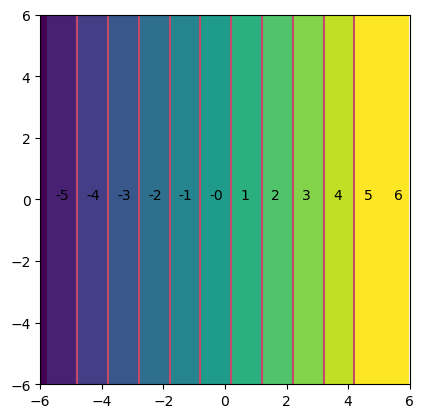

In [119]:
mg1 = MultiGrid(grid_count=5, 
                      grid_bounds=[-5, 5], rotation=0, 
                      base_point = [0, 0],
                      offsets=[.2, .2, .2, .2, .2])
mg1.create_tiles()
mg1.remove_unconnected_tiles()

t = list(mg1.tiles)[0]
t = mg1.tiles[t]

fig, ax = plt.subplots()
ax = mg1.draw_k(ax, 0)
plt.show()

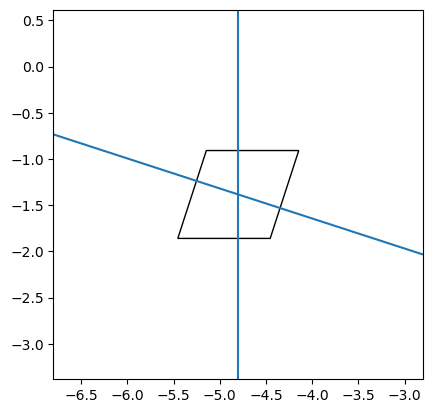

In [103]:
fig, ax = plt.subplots()
ax = t.draw_tile(ax)
plt.show()

In [110]:
for l in t.intersection_lines:
    print([l.angles[0].value, l.angles[1].value])

[-1.5707963267948966, 1.5707963267948966]
[-0.31415926535897937, 2.827433388230814]


0 4.0 [Angle(value=-1.5707963267948966, k=5.0, grid=0), Angle(value=1.5707963267948966, k=4.0, grid=0)]
4 -3.0 [Angle(value=-2.8274333882308142, k=-2.0, grid=4), Angle(value=0.31415926535897887, k=-3.0, grid=4)]
(4.0, 6.0, -1.0, -6.0, -2.0)
(5.0, 6.0, -1.0, -6.0, -2.0)
(5.0, 6.0, -1.0, -6.0, -3.0)
(4.0, 6.0, -1.0, -6.0, -3.0)


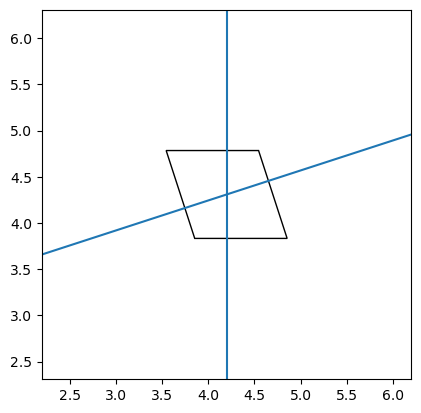

In [5]:
# Draw tile polygon, with lines that make the intersection
t = list(mg1.tiles)[10]
t = mg1.tiles[t]
for l in t.intersection_lines:
    print(l.grid, l.k, l.angles)
for p in t.tile_points:
    print(p)
t.draw_tile()

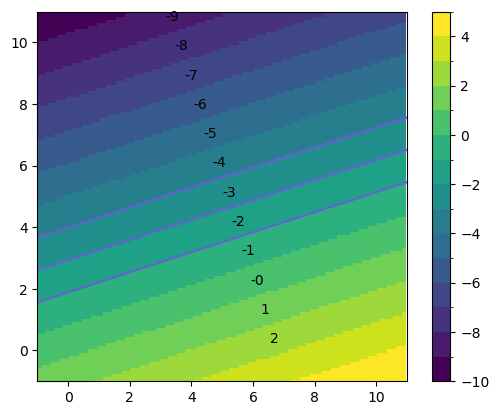

In [ ]:
return graphs that can be added too
graph for oklab
graph for radians

In [41]:
mg1 = MultiGrid(grid_count=4, 
                      grid_bounds=[-1, 2], rotation=0, 
                      base_point = [0, 0],
                      offsets=[.25, .25, .25, .25])
mg1.create_tiles()
mg1.remove_unconnected_tiles()
mg1.save_image(f'output/graph.png')

In [20]:
for i in range(10):
    mg = MultiGrid(seed=i, colors=[])
    mg.create_tiles()
    mg.remove_unconnected_tiles()
    mg.draw_image(f'output/tests/graph_{i:02d}.png')
    print(mg.seed, mg.grid_count, mg.grid_bounds)

0 17 [-7, 8]
1 11 [-6, 7]
2 17 [-4, 5]
3 16 [-2, 3]
4 15 [-9, 10]
5 14 [-8, 9]
6 10 [-6, 7]
7 19 [-7, 8]
8 15 [-4, 5]
9 10 [-8, 9]


In [ ]:
# Could add neighbor ids into the tile class?, that would remove the edge class, then add exception into the tile class?


add graphs for every step within the classes
    like lines and tile (with neighbors)
make sure I can get the common tiling patterns
double check the random color function and make sure we're getting a full range
make the offsets a random draw from 20, so there are more intersections with more than 2 lines